In [1]:
import os
import sys
import numpy as np
try:
    import cv2
except:
    import cv2
import tifffile as tiff
from multiprocessing import Pool
import time
import random
import math
import uuid 
import matplotlib.pyplot as plt
from datetime import datetime
import re
import csv
import json
import elasticdeform
from skimage import draw
from skimage.util import random_noise
from skimage.morphology import convex_hull_image
from scipy.stats import truncnorm
from skimage.draw import line
from skimage.draw import circle
from numba import jit
from skimage.morphology import thin

# Changeable Parameters

In [2]:
IMAGE_DIMENSION = (96, 288)
NUM_NEURON = 5 #int(sys.argv[1]) # 0: Random, 1-n other number of neurons
TIME_FRAMES = 3200
SKIP_TEMPORAL = False
NEURON_AREA_PERCENT = 7
MAX_NOISE_SIGMA = 0.2
SIGNAL_BOOST_FASTOR_MIN = 1.05
SIGNAL_BOOST_FASTOR_MAX = 1.35
GAUSSIAN_BLUR_WINDOW_LEN = 5

DEBUG = 1

# Other Parameters (Recommendation: Do not change below parameters)

In [3]:
# Height of the data
H = IMAGE_DIMENSION[0]

# Width of the data
W = IMAGE_DIMENSION[1]

# Sigma for adding random uniform noise
NOISE_SIGMA = np.random.randint(5,MAX_NOISE_SIGMA*100,1)/100

# Pixels for adding bayesian illumination with focus on center of data
center_brightness_spread = np.random.randint(1,((H/2)*(W/2)/10),1)*1000

pi = math.pi

# Kernel for morphological operations
kernel = np.ones((3,3), np.uint8)

# Area to be occupied by neurons to estimate the size of neurons
area_under_neurons = int((NEURON_AREA_PERCENT/100)*H*W)

if(SKIP_TEMPORAL == True):
    TIME_FRAMES = 50

# Neuron Class

In [4]:
class neuron:
    def __init__(self, ID):
        self.ID = ID
    
    def assign(self, pr, pc, rr, cc, bpr, bpc, brr, bcc):
        
        # Set perimeter coordinates
        self.pr = np.array(pr)
        self.pc = np.array(pc)
        
        # Set inner coordinates
        self.rr = np.array(rr)
        self.cc = np.array(cc)
        
        # Set blur perimeter coordinates
        self.bpr = np.array(bpr)
        self.bpc = np.array(bpc)
        
        # Set blur inner coordinates
        self.brr = np.array(brr)
        self.bcc = np.array(bcc)
        
        
        
        
    def set_excitation(self, et, mem=False, boost=1.0, base=1.0, exc_lvls = {}):
        
        # Set excitation/signal information
        self.et = np.array(et)
        
        # Flag to set higher illuminated membrane
        self.mem = mem
        
        # Set membrane boost factor
        self.mem_boost = boost
        
        # Set baseline neuron intensity
        self.base = base
        
        # Set the neuron excitation levels
        self.exc_lvls = exc_lvls

# Functions

In [5]:
# Generate unique tag ID
def get_tag():
    tag = str(datetime.now())
    tag = re.sub(':|-| ', '', tag)
    tag = str(hex(uuid.getnode()))[2:]+'_'+tag.split('.')[0]
    return tag

In [6]:
# Generate N length random "normal" distribution numbers
def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)


In [7]:
@jit(nopython=True)
def add_at(A, idxv, idxh):
    for i in range(len(idxv)):
        A[idxv[i], idxh[i]] = A[idxv[i], idxh[i]] + 10
    return A

In [8]:
def generate_noisy_frame_cuda():
    noisy = np.array(base_img, dtype='float32')
    A = get_truncated_normal(150, 50, low=0, upp=300)
    horiz_idx = A.rvs(center_brightness_spread)
    horiz_idx = horiz_idx.astype('int')
    B = get_truncated_normal(50, 50, low = 0, upp = 100)
    vert_idx = B.rvs(center_brightness_spread)
    vert_idx = vert_idx.astype('int')
    return add_at(noisy, vert_idx, horiz_idx)

In [9]:
# Apply lighting to neurons and also boost membrane (if True) and signals
def add_illumination(noisy, t):
    
    # add basic lighting
    for i in range(len(neuron_list)):
        
        if(blur_seq[t] == 0):
            rr = neuron_list[i].rr
            cc = neuron_list[i].cc
            pr = neuron_list[i].pr
            pc = neuron_list[i].pc
        else:
            rr = neuron_list[i].brr
            cc = neuron_list[i].bcc
            pr = neuron_list[i].bpr
            pc = neuron_list[i].bpc
            
        membrane_high = neuron_list[i].mem
        base_brightness_factor = neuron_list[i].base
        mem_boost_factor = neuron_list[i].mem_boost
        
        # Set baseline intensity for neurons
        for j in range(len(rr)):
            if(rr[j] < H and rr[j] >= 0 and cc[j] < W and cc[j] >= 0):
                noisy[rr[j], cc[j]] = noisy[rr[j], cc[j]] + base_brightness_factor;
        
        # Check and set membrane intensity
        if(membrane_high == True):
            
            for j in range(len(pr)):
                if(pr[j] < H and pr[j] >= 0 and pc[j] < W and pc[j] >= 0):
                    noisy[pr[j], pc[j]] = noisy[pr[j], pc[j]] * mem_boost_factor;
    
    return noisy

In [10]:
# Apply lighting to neurons and also boost membrane (if True) and signals
def add_excitation(noisy, t):
    
    for i in range(len(neuron_list)):
    
        if(blur_seq[t] == 0):
            rr = neuron_list[i].rr
            cc = neuron_list[i].cc
            pr = neuron_list[i].pr
            pc = neuron_list[i].pc
        else:
            rr = neuron_list[i].brr
            cc = neuron_list[i].bcc
            pr = neuron_list[i].bpr
            pc = neuron_list[i].bpc
            
        
        # If the time frame is excitation for any neuron, perform required illumination
        if(t in neuron_list[i].et):
            neuron_excitation_factor = neuron_list[i].exc_lvls[t]
            for j in range(len(rr)):
                if(rr[j] < H and rr[j] >= 0 and cc[j] < W and cc[j] >= 0):
                    noisy[rr[j], cc[j]] = noisy[rr[j], cc[j]] * (neuron_excitation_factor)
    return noisy

In [11]:
def create_illuminated_data(t):
    return add_illumination(vid[t], t)

In [12]:
def apply_gaussian_parallel(t):
    img = cv2.GaussianBlur(vid_illum[t], (GAUSSIAN_BLUR_WINDOW_LEN,GAUSSIAN_BLUR_WINDOW_LEN), 0)
    if(blur_seq[t] != 0):
        img = cv2.GaussianBlur(img, (blur_seq[t],blur_seq[t]), 0)
    return img

In [13]:
def apply_median_parallel(t):
    return cv2.medianBlur(vid_illum[t], 3)
    


In [14]:
# Generate temporal ground truth in parallel pool
def generate_temporal_gt(t):
    img = np.zeros((H, W), dtype='uint8')
    for neu in neuron_list:
        rr = neu.rr
        cc = neu.cc
        if(t in neu.et):
            for j in range(len(rr)):
                if(rr[j] < H and rr[j] >= 0 and cc[j] < W and cc[j] >= 0):
                    img[rr[j], cc[j]] = 255
    return img

In [15]:
def show_frame(img, title='none'):
    plt.figure(figsize=(15,8))
    plt.imshow(img, cmap='gray')
    if(title != 'none'):
        plt.title(title)
    plt.axis('off')
    plt.show()

In [16]:
def apply_photobleach_parallel(t):
    A = (math.exp(-0.0008 * t)+3)/4
    return data[t]*A

In [17]:
def base_blood_vessel_illumination(x):
    frame = data[x]
    for i in vessel_pts:
        rr, cc = i
        if(rr >= 0 and rr < H and cc >= 0 and cc < W): 
            frame[rr, cc] = frame[rr, cc] + blood_vessel_base_brightness
    return frame

# Main Operations

In [18]:
# Generate unique tag ID
tag = get_tag()

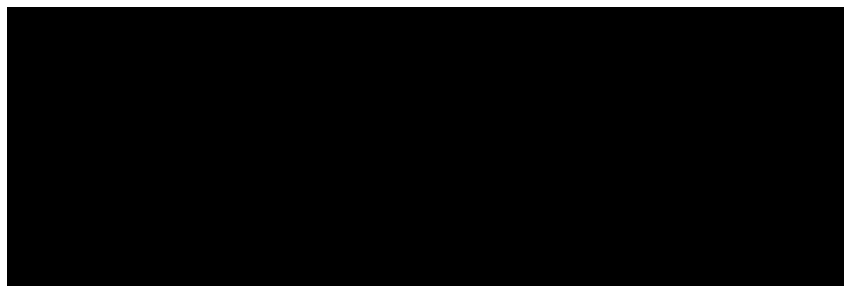

In [19]:
# Generate a base line image
base_img = np.ones((H, W), dtype='float32')
if(DEBUG):
    show_frame(base_img)

### If not provided, randomly identify the number of neurons to be generated

In [20]:
if(NUM_NEURON == 0): #Random
    
    # Neuron selection is not uniform, rather it is normal distribution with emphasis on lower neuron count.
    mu, sigma = 0, 1
    s = np.random.normal(mu, sigma, 1000)
    s = s/s.max()
    while True:
        num_neurons = int(abs(s[np.random.randint(0, len(s), 1)])*100)
        if(num_neurons > 0 and num_neurons < 30):
            break
else:
    num_neurons = NUM_NEURON
print("<"+tag+"> "+"Number of Neurons:", num_neurons)

<33121fabf28a_20200615115538> Number of Neurons: 5


### Neuron location creation

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: Input image is entirely zero, no valid convex hull. Returning empty image


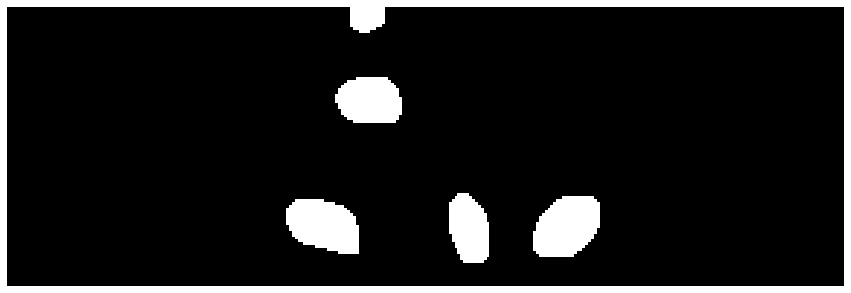

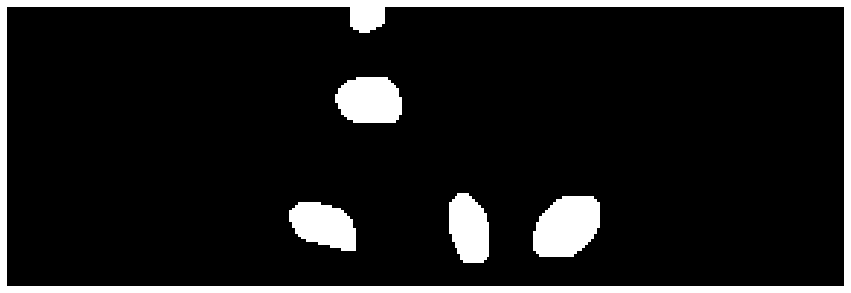

In [25]:
from skimage.morphology import diamond

# For each neuron, identify the perimeter and fill coordinates
while True:
    error_flag = True
    if(DEBUG):
        img = np.zeros((H,W), dtype='uint8')
        bimg = np.zeros((H,W), dtype='uint8')
    neuron_list = []
    for i in range(0, num_neurons):
#         print("n:", i)
        # Identify the size of neuron, such that, one side of ellipse is not more than twice of other.
        while True:
            ra = np.random.randint(4,50,1)[0]
            if(num_neurons > 15):
                area_neuron = area_under_neurons / num_neurons
            else:
                area_neuron = area_under_neurons / 15
            rb = area_neuron / (pi * ra)
            ratio = ra/rb
            if(ratio > 0.2 and ratio < 5):
                break
        
        # Create a neuron class object
        neu = neuron(i)
        
        # Randomly choose the center coordinates within the region of interest
        r = np.random.randint(5, H-5, 1)
        c= np.random.randint(int(W/4), int(3*W/4),1)
        angle = np.random.randint(-90, 90, 1)
        
        # Create a workspace to play with
        wrksp = np.zeros((H, W), dtype='uint8')
        rr, cc = draw.ellipse(r,c,ra,rb, rotation=np.deg2rad(angle))
        for i in range(len(rr)):
            if(rr[i] < H and rr[i] >= 0 and cc[i] < W and cc[i] >= 0):
                wrksp[rr[i], cc[i]] = 255
#         show_frame(wrksp)
        wrksp = elasticdeform.deform_random_grid(wrksp, sigma=15, points=2)
        wrksp[wrksp > 128] = 255
        wrksp[wrksp < 255] = 0
#         show_frame(wrksp,"Elastic")
        wrksp = cv2.morphologyEx(wrksp, cv2.MORPH_CLOSE, kernel)
#         show_frame(wrksp, "Close")
        
        _, markers = cv2.connectedComponents(wrksp)
#         show_frame(markers,"Markers")
        wrksp = np.zeros((H, W), dtype='uint8')
        for i in range(1, markers.max()+1):
            img1 = ((markers == i)).astype('uint8')*255
#             show_frame(img, "Marker " + str(i))
#             print(img1.sum()/255, area_neuron)
            if((img1.sum()/255) > (0.5 * area_neuron) and (img1.sum()/255) < (2 * area_neuron)):
                wrksp = cv2.add(wrksp, img1)
        wrksp = convex_hull_image(wrksp)
        wrksp = wrksp.astype('uint8')*255
#         show_frame(wrksp)
        
        bwrksp = cv2.erode(wrksp, kernel, iterations=0) 
        
        
        # Find the perimeter (edges)
        edge = cv2.Canny(wrksp, 100, 255)
        
        # If number of neurons is less than 20, perform random dilations
        num_dilation = 0
        if(num_neurons < 20):
            num_dilation = np.random.randint(0,2,1)
        edge = cv2.dilate(edge, kernel, iterations=num_dilation) 
        
        # Refill the edge to get accurate fill coordinates, as above found coordinates 
        # while create ellipse might not include the dilation corrdinations
        indices = np.where(edge != [0])
        pr = indices[0]
        pc = indices[1]
        wrksp = np.zeros((H, W), dtype='uint8')
        for i in range(len(pr)):
            if(pr[i] < H and pr[i] >= 0 and pc[i] < W and pc[i] >= 0):
                wrksp[pr[i], pc[i]] = 1
        
        if(wrksp.sum() == 0):
#             print("<"+tag+"> "+"Error: Convex hull found blank image ")
            error_flag = True
            break
        else:
            error_flag = False
        
        
        chull = convex_hull_image(wrksp)
        
        
        indices = np.where(chull != [0])
        rr = indices[0]
        cc = indices[1]
        
        if(DEBUG):
            # Set baseline intensity for neurons
            for j in range(len(rr)):
                if(rr[j] < H and rr[j] >= 0 and cc[j] < W and cc[j] >= 0):
                    img[rr[j], cc[j]] = 255


        # Blur handling
        # Find the perimeter (edges)
        bedge = cv2.Canny(bwrksp, 100, 255)
        
        # If number of neurons is less than 20, perform random dilations
        bnum_dilation = 0
        if(num_neurons < 20):
            bnum_dilation = np.random.randint(0,2,1)
        bedge = cv2.dilate(bedge, np.ones((1,1), np.uint8) , iterations=bnum_dilation) 
        
        # Refill the edge to get accurate fill coordinates, as above found coordinates 
        # while create ellipse might not include the dilation corrdinations
        bindices = np.where(bedge != [0])
        bpr = bindices[0]
        bpc = bindices[1]
        bwrksp = np.zeros((H, W), dtype='uint8')
        for i in range(len(bpr)):
            if(bpr[i] < H and bpr[i] >= 0 and bpc[i] < W and bpc[i] >= 0):
                bwrksp[bpr[i], bpc[i]] = 1
        bchull = convex_hull_image(bwrksp)
        bindices = np.where(bchull != [0])
        brr = bindices[0]
        bcc = bindices[1]
        if(DEBUG):
            # Set baseline intensity for neurons
            for j in range(len(brr)):
                if(brr[j] < H and brr[j] >= 0 and bcc[j] < W and bcc[j] >= 0):
                    bimg[brr[j], bcc[j]] = 255    
        # Assign the information to neuron object
        neu.assign(pr, pc, rr, cc, bpr, bpc, brr, bcc)
        
        # Append to the list of npeurons
        neuron_list.append(neu)  
    if(error_flag == False):
        break


if(DEBUG):
    show_frame(img)
    show_frame(bimg)

### Create excitation

In [26]:
for i in range(len(neuron_list)):
    et = np.random.randint(0, TIME_FRAMES, np.random.randint(0, TIME_FRAMES/50, 1))
    et.sort()
    neu_exc_level = {}
    for j in et:
        neu_exc_level[j] = random.uniform(SIGNAL_BOOST_FASTOR_MIN, SIGNAL_BOOST_FASTOR_MAX)
    
    membrane_high = np.random.choice(2, 1, p=[0.2, 0.8])[0].astype('bool')
    mem_boost_factor = random.uniform(1.5,2.0)
    base_brightness_factor = random.uniform(0.03,0.1)
    neuron_list[i].set_excitation(et, membrane_high, mem_boost_factor, base_brightness_factor, neu_exc_level)

In [57]:
neuron_list[2].pr

array([64, 64, 65, 65, 65, 65, 66, 66, 66, 66, 67, 67, 67, 68, 68, 68, 69,
       69, 70, 70, 71, 71, 72, 72, 73, 73, 74, 74, 75, 75, 76, 76, 77, 77,
       78, 78, 79, 79, 80, 80, 81, 81, 82, 82, 83, 83, 84, 84, 85, 85, 85,
       86, 86, 86, 87, 87, 87, 87, 87, 87, 87])

### Create time-series data

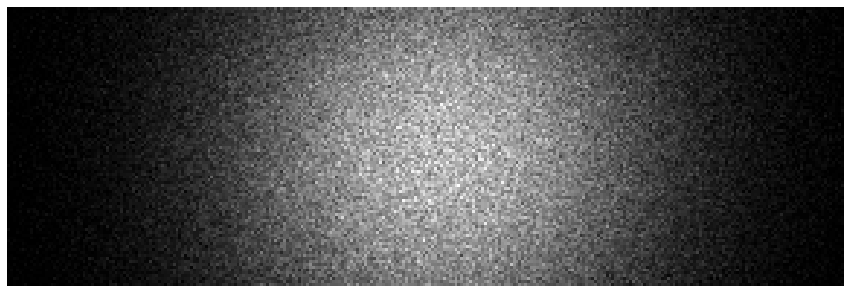

In [47]:
# vid = tiff.imread(sys.argv[2])
vid = tiff.imread('../base_data/data/157eea70aaa8_20200102164941.tif')
vid = vid.astype('float32')
vid = vid - vid.min()
vid = vid / vid.max()
if(DEBUG):
    show_frame(vid[0])


### Insert random intense blurring

In [48]:
blur_seq = []
isBlurSet = False
for i in range(TIME_FRAMES):
    if(isBlurSet == False):
        isBlur = np.random.choice(2, 1, p=[0.995, 0.005])[0]
        if(isBlur == 0):
            blur_seq.append(0)
        else:
            isBlurSet = True
            blurLen = np.random.randint(3, 50)
            blurCount = 0
            lowIntenseCountS = int(blurLen / 4)
            lowIntenseCountE = blurLen - int(blurLen / 4) - 1
    if(isBlurSet == True):
        if(blurCount <= lowIntenseCountS or blurCount>= lowIntenseCountE):
            blur_seq.append(5)
        else:
            blur_seq.append(7)
        blurCount = blurCount + 1
        if(blurCount == blurLen):
            isBlurSet = False

### Illumination: Add appropriate illumination for neuron and signals

<33121fabf28a_20200615115538> Time taken to illuminate time series frames: 2.58 seconds


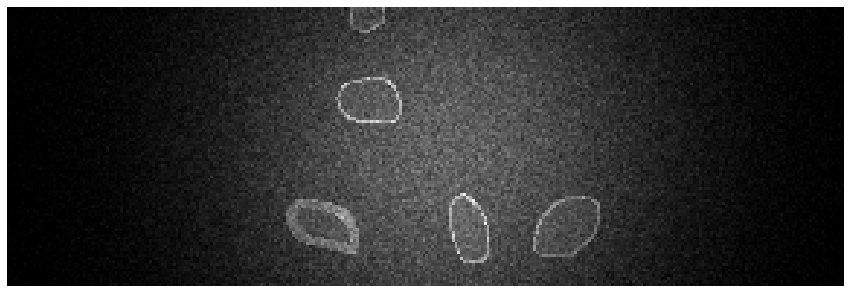

In [49]:
tic = time.time()
pool = Pool()
pool_out = pool.map(create_illuminated_data, range(TIME_FRAMES))
pool.close()
pool.terminate()
toc = time.time()
print("<"+tag+"> "+"Time taken to illuminate time series frames:", round(toc-tic, 2), "seconds")
vid_illum = pool_out


if(DEBUG):
    show_frame(vid_illum[0])


### Gaussian Smoothing of neuron intensities

<33121fabf28a_20200615115538> Time taken to smooth time series frames: 1.62 seconds


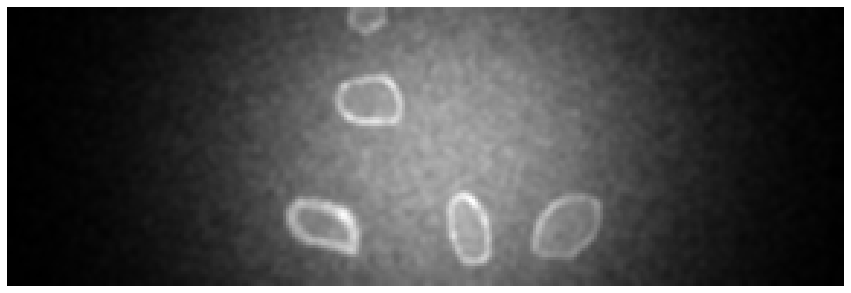

In [50]:
tic = time.time()
pool = Pool()
pool_out = pool.map(apply_gaussian_parallel, range(TIME_FRAMES))
pool.close()
pool.terminate()
toc = time.time()
print("<"+tag+"> "+"Time taken to smooth time series frames:", round(toc-tic, 2), "seconds")
vid_illum = pool_out


if(DEBUG):
    show_frame(vid_illum[0])

### Final stage noise addition

<33121fabf28a_20200615115538> Time taken to add random noise: 5.84 seconds


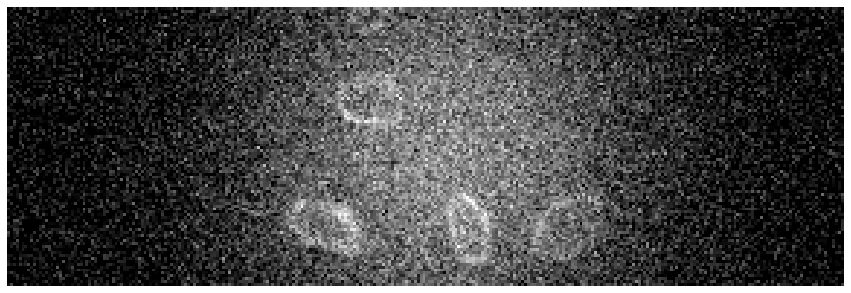

In [51]:
Fs = 200
f = 1
sample = TIME_FRAMES
x = np.arange(sample)
y = np.sin(2 * np.pi * f * x / Fs)/50


tic = time.time()
pool_out = []
for i in range(TIME_FRAMES):
    pool_out.append(random_noise(vid_illum[i], mean = y[i], var=NOISE_SIGMA**2))
toc = time.time()
print("<"+tag+"> "+"Time taken to add random noise:", round(toc-tic, 2), "seconds")
vid_illum = pool_out


if(DEBUG):
    show_frame(vid_illum[0])

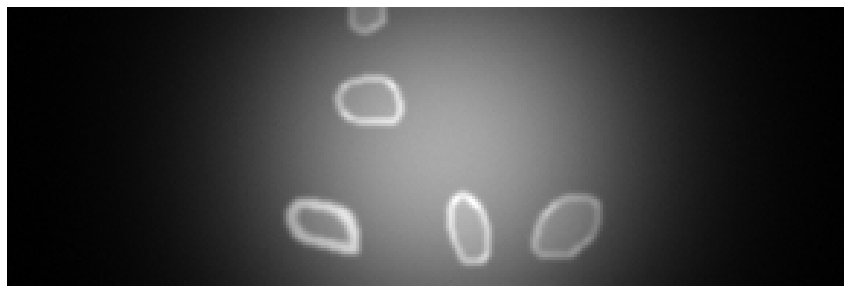

In [52]:
show_frame(np.average(np.array(vid_illum, dtype='float32'), axis=0))

### Add excitation

<33121fabf28a_20200615115538> Time taken to add neuron excitation intensity changes: 0.26 seconds


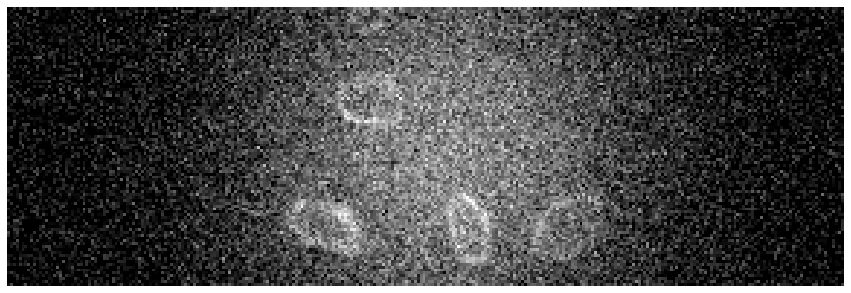

In [53]:
tic = time.time()
pool_out = []
for i in range(TIME_FRAMES):
    pool_out.append(add_excitation(vid_illum[i], i))
toc = time.time()
print("<"+tag+"> "+"Time taken to add neuron excitation intensity changes:", round(toc-tic, 2), "seconds")
vid_illum = np.array(pool_out, dtype='float32') * 2.0


# Normalize the output
vid_illum = vid_illum-vid_illum.min()
vid_illum = vid_illum/vid_illum.max()


if(DEBUG):
    show_frame(vid_illum[0])

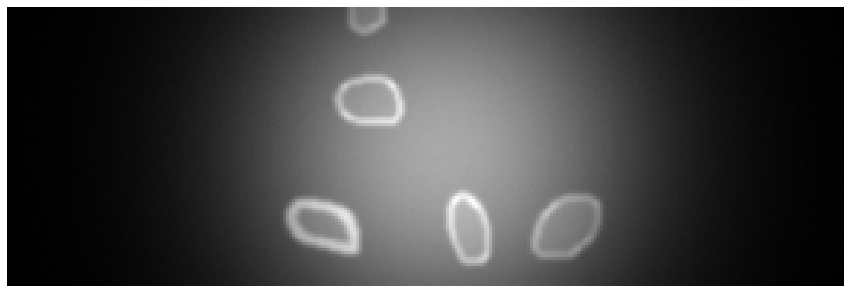

In [54]:
show_frame(np.average(vid_illum, axis=0))

### Photo-bleaching

In [58]:
tic = time.time()
data = vid_illum
pool = Pool()
pool_out = pool.map(apply_photobleach_parallel, range(TIME_FRAMES))
pool.close()
pool.terminate()
toc = time.time()
print("<"+tag+"> "+"Time taken to photo-bleach:", round(toc-tic, 2), "seconds")
vid_illum = np.array(pool_out, dtype='float32')

<33121fabf28a_20200615115538> Time taken to photo-bleach: 2.93 seconds


### Add blood vessels

160.12355042752927
138.53744670403037
118.78178476297745
97.62288261734493
131.6820175773985
103.96438585060592


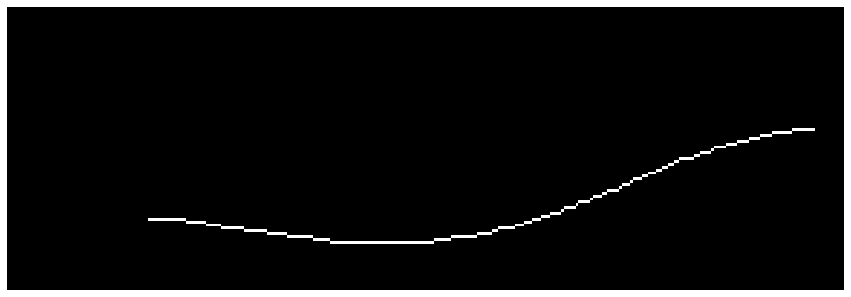

<33121fabf28a_20200615115538> Time taken to add blood vessel activity: 5.91 seconds


In [59]:
p = np.random.randint(0, 2, 1)[0]
p=1
if(p == 1):
    tic = time.time()
    while True:
        while True:

            cc1 = np.random.randint(0, W, 1)[0]
            rr1 = np.random.randint(0, H/2, 1)[0]

            cc2 = np.random.randint(0, W, 1)[0]
            rr2 = np.random.randint(H/2, H, 1)[0]

            dist = math.sqrt((cc2 - cc1)**2 + (rr2 - rr1)**2)  
            rad = math.atan2((rr1-rr2),(cc2-cc1))
            angle = math.degrees(rad)

            d = 1 + abs(math.sin(rad))

            # Change minimum distance according to angle of line
            print(0.9*d*H)
            if(dist < 0.9*d*H):
                continue
            if(abs(angle) > 15):
                break


        X = np.zeros((H, W))
        rr, cc = draw.line(rr1,cc1,rr2,cc2)
        X[rr, cc] = 255
        X_deformed = elasticdeform.deform_random_grid(X, sigma=20, points=3)
        X_deformed[X_deformed > 128] = 255
        X_deformed[X_deformed < 255] = 0
        dilated = cv2.dilate(X_deformed,kernel,iterations = 8)
        closing = thin(dilated)

        rr, cc = np.where(closing == True)
        coords = [(rr[i], cc[i]) for i in range(len(rr))]

        img1 = np.zeros((closing.shape[0]+2, closing.shape[1]+2),dtype='uint8')
        img1[1:-1, 1:-1] = np.array(closing, dtype='uint8')

        val = 1

        ends = []
        for c in coords:
            if(img1[c[0]:c[0]+3, c[1]:c[1]+3].sum() == 2):
                ends.append(c)

        if(len(ends) != 2):
            continue

        i, j = ends[0]
        pp = (1,1)
        traj=[]
        while True:
            traj.append((i, j))
            if((i, j) == ends[1]):
                break

            mask = np.ones((3,3), dtype='uint8')
            mask[1,1] = 0
            mask[pp] = 0
            wrksp = img1[i:i+3, j:j+3]
            res = cv2.multiply(wrksp, mask)
            loc = np.where(res == 1)
            rp = (loc[0][0]-1, loc[1][0]-1)
            i, j = i+rp[0], j+rp[1]
            x = loc[1][0]
            y = loc[0][0]
            if (x == 0):
                x = 2
            elif (x == 2):
                x = 0
            if (y == 0):
                y = 2
            elif (y == 2):
                y = 0
            pp = (y, x)        

        if(len(traj) == img1.sum()):
            break  
    if(DEBUG):
        show_frame(img1)
    
    blood_vessel_base_brightness = np.random.uniform(0.02, 0.06, 1)
    img = img1[1:-1, 1:-1]
    img = cv2.dilate(img, kernel, iterations=1)
    vessel_ptsy, vessel_ptsx = np.where(img == 1)
    vessel_pts = [(vessel_ptsy[m], vessel_ptsx[m]) for m in range(len(vessel_ptsx)) ]
    
    pool = Pool()
    pool_out = pool.map(base_blood_vessel_illumination, range(TIME_FRAMES))
    pool.close()
    pool.terminate()
    vid_illum = np.array(pool_out, dtype='float32')
    
    # Normalize the output
    vid_illum = vid_illum-vid_illum.min()
    vid_illum = vid_illum/vid_illum.max()
    
    mov_counts = np.random.randint(5, 18, 1)[0]
    sps = np.random.randint(0, TIME_FRAMES-len(traj), mov_counts)
    
    for j in sps:
        blood_brightness = np.random.uniform(1.1, 1.3, 1)[0]
        rad = np.random.uniform(2, 5, 1)[0]
        for ctr in range(len(traj)):
            pt = traj[ctr]
            rr, cc = circle(pt[0], pt[1], rad)
            for idxc in range(len(rr)):
                if(rr[idxc] < H and rr[idxc] >= 0 and cc[idxc] < W and cc[idxc] >= 0):
                    vid_illum[j+ctr][rr[idxc], cc[idxc]] = vid_illum[j+ctr][rr[idxc], cc[idxc]] * blood_brightness
    toc = time.time()
    print("<"+tag+"> "+"Time taken to add blood vessel activity:", round(toc-tic, 2), "seconds")

<33121fabf28a_20200615115538> Time taken to smooth time series frames: 3.05 seconds


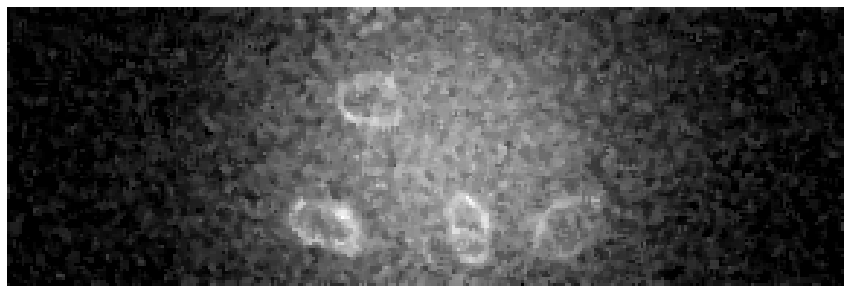

In [60]:

tic = time.time()
pool = Pool()
pool_out = pool.map(apply_median_parallel, range(TIME_FRAMES))
pool.close()
pool.terminate()
toc = time.time()
print("<"+tag+"> "+"Time taken to smooth time series frames:", round(toc-tic, 2), "seconds")
vid_illum = np.array(pool_out, dtype='float32')


if(DEBUG):
    show_frame(vid_illum[0])

<33121fabf28a_20200615115538> Time taken to smooth time series frames: 3.67 seconds


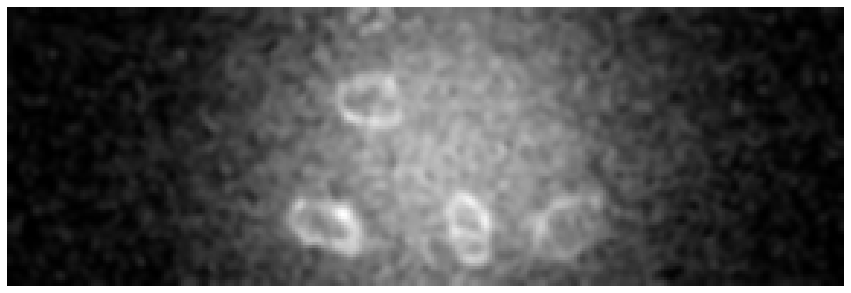

In [61]:
tic = time.time()
pool = Pool()
pool_out = pool.map(apply_gaussian_parallel, range(TIME_FRAMES))
pool.close()
pool.terminate()
toc = time.time()
print("<"+tag+"> "+"Time taken to smooth time series frames:", round(toc-tic, 2), "seconds")
vid_illum = np.array(pool_out, dtype='float32')


if(DEBUG):
    show_frame(vid_illum[0])

In [62]:
vid_illum = np.array(vid_illum, dtype='float32')




In [63]:
# Normalize the output
vid_illum = vid_illum-vid_illum.min()
vid_illum = vid_illum/vid_illum.max()   

In [64]:
vid_illum = (vid_illum * 255).astype('uint8')

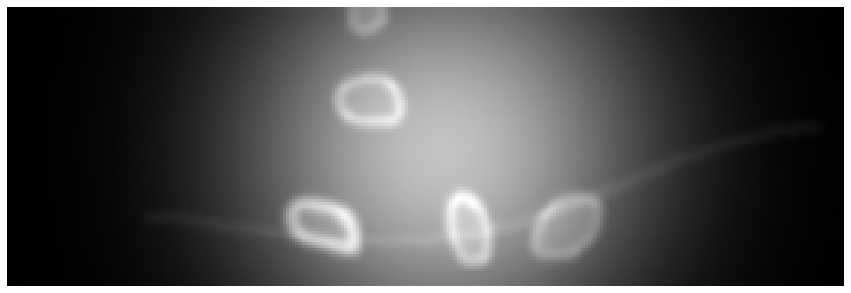

In [65]:
show_frame(np.average(vid_illum, axis=0))

In [ ]:
# Now this is too good, while as a single frame it is still competitive.

In [69]:
tiff.imsave('test_data/data.tif', vid_illum)
tiff.imsave('test_data/spatial_label.tif', spatial_gt)
tiff.imsave('test_data/temporal_label.tif', temporal_gt)


# Ground Truth Creation

### Spatial Ground Truth

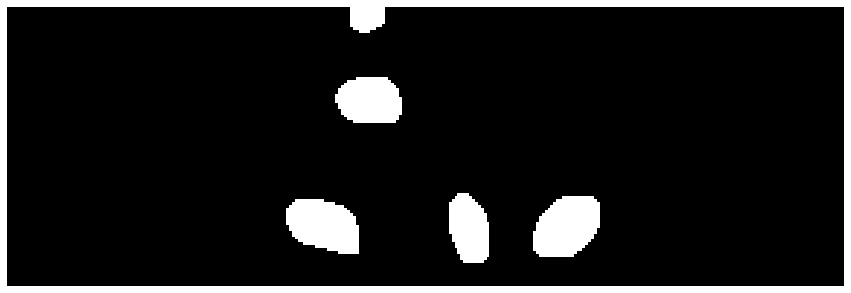

In [66]:
spatial_gt = np.zeros((H, W), dtype='uint8')
for neu in neuron_list:
    rr = neu.rr
    cc = neu.cc
    for j in range(len(rr)):
        if(rr[j] < H and rr[j] >= 0 and cc[j] < W and cc[j] >= 0):
            spatial_gt[rr[j], cc[j]] = 255

if(DEBUG):
    show_frame(spatial_gt)

### Temporal Ground Truth

In [68]:
if(SKIP_TEMPORAL == False):
    tic = time.time()
    pool = Pool()
    pool_out = pool.map(generate_temporal_gt, range(TIME_FRAMES))
    pool.close()
    pool.terminate()
    toc = time.time()
    print("<"+tag+"> "+"Time taken to generate temporal ground truth:", round(toc-tic, 2), "seconds")
    temporal_gt = np.array(pool_out, dtype='uint8')

<33121fabf28a_20200615115538> Time taken to generate temporal ground truth: 2.99 seconds


# Store files

In [ ]:
neu_data = {}

for i in range(0, num_neurons):
    neu_data[str("neuron_" + str(i))] = {"et":str(list(neuron_list[i].et)), "mem":str(neuron_list[i].mem), "mem_boost":str(neuron_list[i].mem_boost), "base":str(neuron_list[i].base), "exc_lvls":str(neuron_list[i].exc_lvls), "pr":str(list(neuron_list[i].pr)), "pc":str(list(neuron_list[i].pc)), "rr":str(list(neuron_list[i].rr)), "cc":str(list(neuron_list[i].cc))}

if(SKIP_TEMPORAL == False):
    if not os.path.exists('whole_datasets'):
        os.mkdir('whole_datasets')

    if not os.path.exists('whole_datasets/data'):
        os.mkdir('whole_datasets/data')
    tiff.imsave('whole_datasets/data/'+tag+'_%d.tif' %num_neurons, vid_illum)

    if not os.path.exists('whole_datasets/spatial_label'):
        os.mkdir('whole_datasets/spatial_label')
    tiff.imsave('whole_datasets/spatial_label/'+tag+'_%d.tif' %num_neurons, spatial_gt)

    if not os.path.exists('whole_datasets/info'):
        os.mkdir('whole_datasets/info')
    with open('whole_datasets/info/'+tag+'_%d.json' %num_neurons, "w") as write_file:
        json.dump(neu_data, write_file)  

    if not os.path.exists('whole_datasets/temporal_label'):
        os.mkdir('whole_datasets/temporal_label')
    tiff.imsave('whole_datasets/temporal_label/'+tag+'_%d.tif' %num_neurons, temporal_gt)

    f= open("whole_datasets/neuron_info.txt","a+")
    f.write(str(tag+": "+str(num_neurons)+"\n"))
    f.close()
    
else:
    if not os.path.exists('spatial_datasets'):
        os.mkdir('spatial_datasets')

    if not os.path.exists('spatial_datasets/data'):
        os.mkdir('spatial_datasets/data')
    tiff.imsave('spatial_datasets/data/'+tag+'_%d.tif' %num_neurons, vid_illum[0])

    if not os.path.exists('spatial_datasets/spatial_label'):
        os.mkdir('spatial_datasets/spatial_label')
    tiff.imsave('spatial_datasets/spatial_label/'+tag+'_%d.tif' %num_neurons, spatial_gt)
    
    if not os.path.exists('spatial_datasets/info'):
        os.mkdir('spatial_datasets/info')
    with open('spatial_datasets/info/'+tag+'_%d.json' %num_neurons, "w") as write_file:
        json.dump(neu_data, write_file)
    
    f= open("spatial_datasets/neuron_info.txt","a+")
    f.write(str(tag+": "+str(num_neurons)+"\n"))
    f.close()